In [1]:
import os
import sys
os.environ["JAVA_HOME"] = "/Users/jedrzej/Library/Java/JavaVirtualMachines/openjdk-23.0.2/Contents/Home"
os.environ["JDK_JAVA_OPTIONS"] = "-Djava.security.manager=allow"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan, avg
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, desc, month, dayofmonth
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import avg, hour, floor
from pyspark.sql.functions import to_date, month, dayofmonth
from pyspark.sql.types import IntegerType, DoubleType
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

spark = SparkSession.builder \
    .appName("FlightDelayPrediction") \
    .config("spark.driver.memory", "12g") \
    .config("spark.driver.maxResultSize", "4g") \
    .master("local[*]") \
    .getOrCreate()

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


NOTE: Picked up JDK_JAVA_OPTIONS: -Djava.security.manager=allow
NOTE: Picked up JDK_JAVA_OPTIONS: -Djava.security.manager=allow
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/02 18:39:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/02 18:39:33 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# 1. Data Loading and Cleaning


In [3]:
df = spark.read.csv("Flight_delay.csv", header=True, inferSchema=True)
print(f"Original row count: {df.count()}")

numeric_cols_to_cast = [
    "ArrDelay", "DepDelay", "Distance", "DayOfWeek", "Month", "Day",
    "TaxiIn", "TaxiOut", "CarrierDelay", "WeatherDelay", "NASDelay", 
    "SecurityDelay", "LateAircraftDelay", "ActualElapsedTime", 
    "AirTime", "DepTime", "ArrTime", "CRSArrTime", "CRSElapsedTime"
]

df_clean = df.filter((col("Cancelled") == 0) & (col("Diverted") == 0)).drop("Cancelled", "Diverted")

existing_cols = df.columns
cols_to_cast = [c for c in numeric_cols_to_cast if c in existing_cols]

for c in cols_to_cast:
    df_clean = df_clean.withColumn(c, col(c).cast("double"))

df_clean = df_clean.dropna(subset=["ArrDelay", "DepDelay"])
print(f"Row count after cleaning: {df_clean.count()}")

df_clean.cache()


Original row count: 484551
Row count after cleaning: 484551


25/12/02 18:39:41 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[DayOfWeek: double, Date: string, DepTime: double, ArrTime: double, CRSArrTime: double, UniqueCarrier: string, Airline: string, FlightNum: int, TailNum: string, ActualElapsedTime: double, CRSElapsedTime: double, AirTime: double, ArrDelay: double, DepDelay: double, Origin: string, Org_Airport: string, Dest: string, Dest_Airport: string, Distance: double, TaxiIn: double, TaxiOut: double, CancellationCode: string, CarrierDelay: double, WeatherDelay: double, NASDelay: double, SecurityDelay: double, LateAircraftDelay: double]

# 2. Basic Statistics


In [8]:
df.show(5)

+---------+----------+-------+-------+----------+-------------+--------------------+---------+-------+-----------------+--------------+-------+--------+--------+------+--------------------+----+--------------------+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|DayOfWeek|      Date|DepTime|ArrTime|CRSArrTime|UniqueCarrier|             Airline|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|         Org_Airport|Dest|        Dest_Airport|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+---------+----------+-------+-------+----------+-------------+--------------------+---------+-------+-----------------+--------------+-------+--------+--------+------+--------------------+----+--------------------+--------+------+-------+---------+----------------+--------+------------+------------+--------+----

In [9]:
display_cols = ["ArrDelay", "DepDelay", "Distance", "ActualElapsedTime"]
df_clean.select([c for c in display_cols if c in df_clean.columns]).summary().show()

+-------+------------------+------------------+-----------------+------------------+
|summary|          ArrDelay|          DepDelay|         Distance| ActualElapsedTime|
+-------+------------------+------------------+-----------------+------------------+
|  count|            484551|            484551|           484551|            484551|
|   mean| 60.90776409500754| 57.49808585680351|752.1426887984959|134.81042243231363|
| stddev|56.975420383828165|55.991012368506205|571.6311237228965| 74.07037431845504|
|    min|              15.0|               6.0|             31.0|              15.0|
|    25%|              25.0|              23.0|            331.0|              80.0|
|    50%|              42.0|              40.0|            599.0|             116.0|
|    75%|              76.0|              72.0|            992.0|             168.0|
|    max|            1707.0|            1710.0|           4502.0|             727.0|
+-------+------------------+------------------+-----------------+

# 3. Univariate Analysis
## Distribution of Arrival Delay


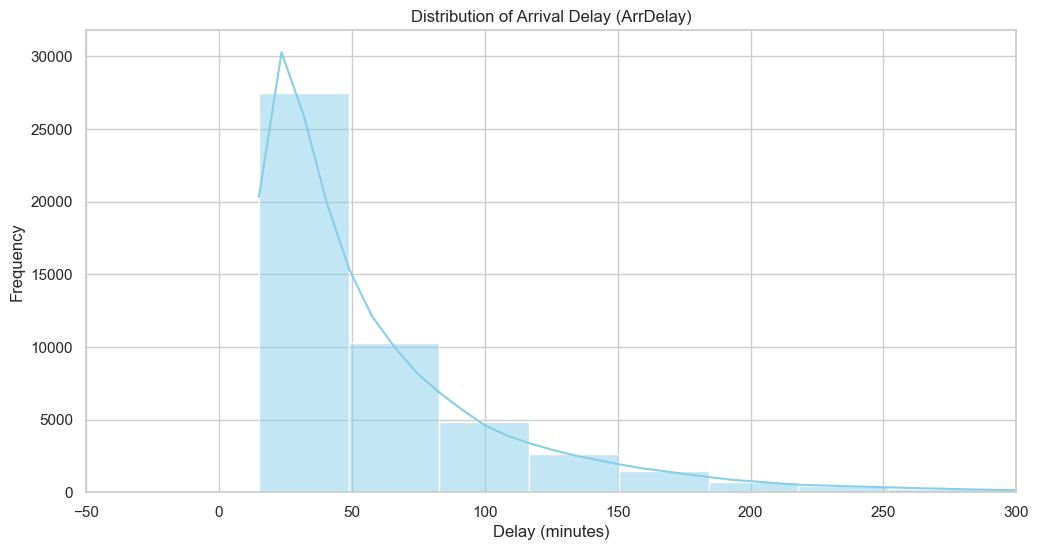

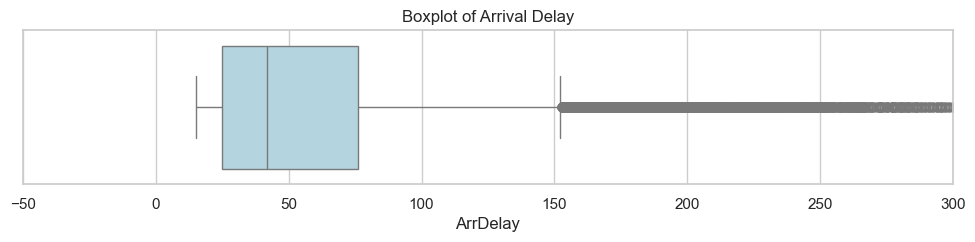

In [37]:
# Convert to Pandas for plotting (sample if too large)
pdf = df_clean.select("ArrDelay").sample(False, 0.1, seed=42).toPandas()

plt.figure(figsize=(12, 6))
sns.histplot(pdf["ArrDelay"], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Arrival Delay (ArrDelay)")
plt.xlabel("Delay (minutes)")
plt.ylabel("Frequency")
plt.xlim(-50, 300) # Limit x-axis to focus on common range
plt.show()

plt.figure(figsize=(12, 2))
sns.boxplot(x=pdf["ArrDelay"], color='lightblue')
plt.title("Boxplot of Arrival Delay")
plt.xlim(-50, 300)
plt.show()


## Distribution of Departure Delay


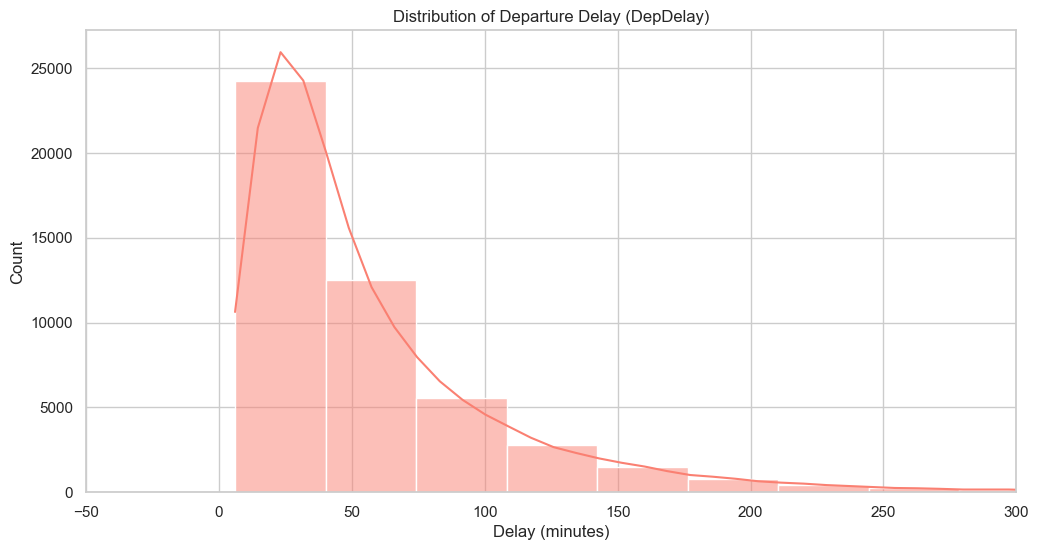

In [38]:
pdf_dep = df_clean.select("DepDelay").sample(False, 0.1, seed=42).toPandas()

plt.figure(figsize=(12, 6))
sns.histplot(pdf_dep["DepDelay"], bins=50, kde=True, color='salmon')
plt.title("Distribution of Departure Delay (DepDelay)")
plt.xlabel("Delay (minutes)")
plt.xlim(-50, 300)
plt.show()


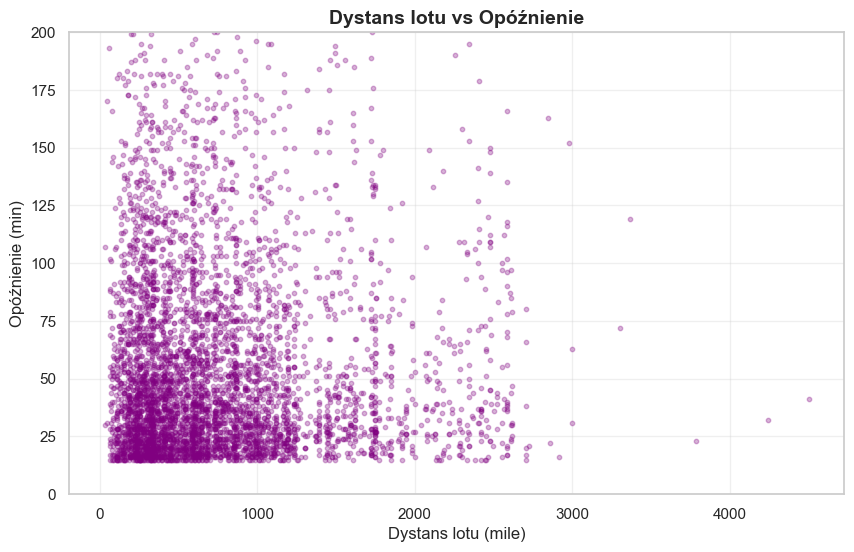

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

total_rows = df_clean.count()
desired_sample_size = min(5000, total_rows)

if total_rows > 0 and desired_sample_size < total_rows:
    fraction_to_sample = desired_sample_size / total_rows
    sample_spark_df = df_clean.sample(False, fraction_to_sample, seed=42)
else:
    sample_spark_df = df_clean

sample_plot = sample_spark_df.limit(desired_sample_size).toPandas()

ax.scatter(sample_plot['Distance'], sample_plot['ArrDelay'],
                   alpha=0.3, s=10, color='purple')
ax.set_xlabel('Dystans lotu (mile)', fontsize=12)
ax.set_ylabel('Opóźnienie (min)', fontsize=12)
ax.set_title('Dystans lotu vs Opóźnienie', fontsize=14, fontweight='bold')
ax.set_ylim(0, 200)
ax.grid(True, alpha=0.3)
plt.show()

# 4. Bivariate Analysis
## Correlation Matrix (All Variables)


Calculating correlation for 18 variables: ['DayOfWeek', 'DepTime', 'ArrTime', 'CRSArrTime', 'FlightNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']


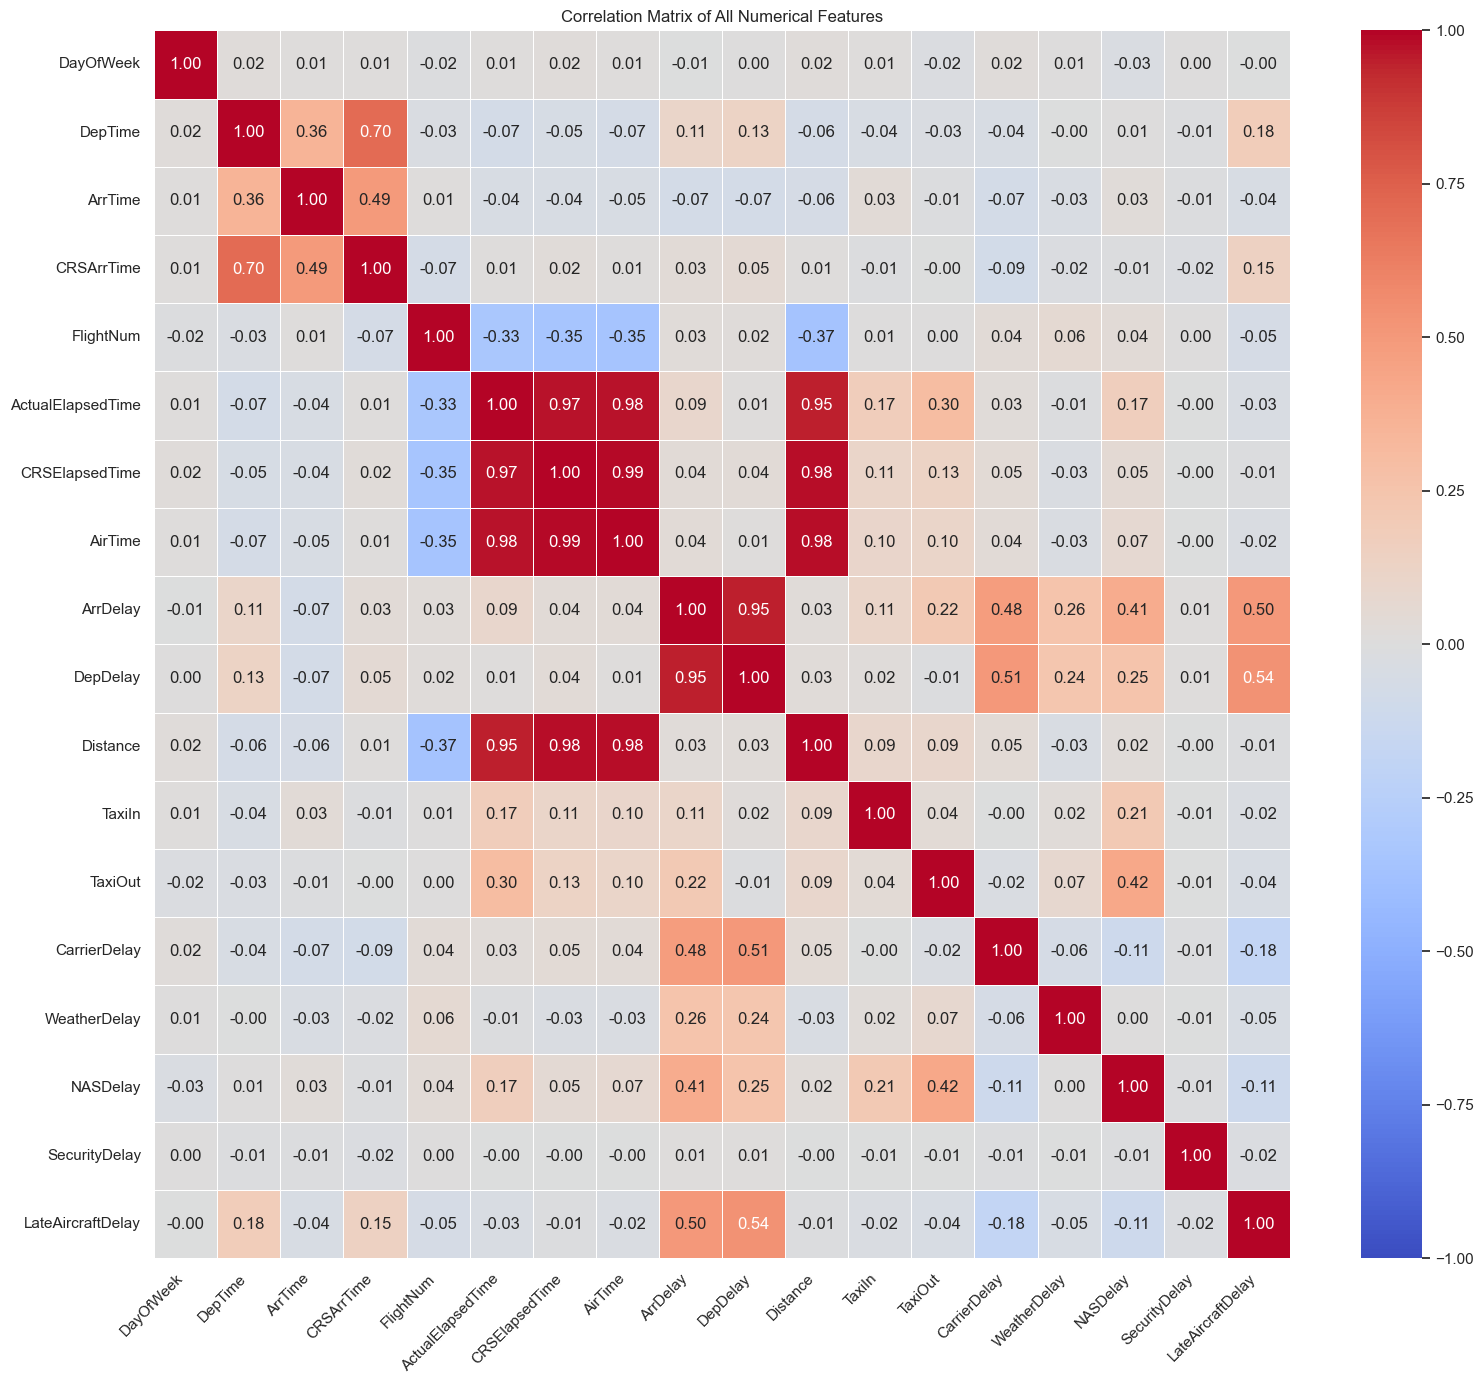

In [ ]:
numeric_types = ['IntegerType', 'DoubleType', 'LongType']
numeric_cols = [f.name for f in df_clean.schema.fields if str(f.dataType).replace("()","") in numeric_types or "Integer" in str(f.dataType) or "Double" in str(f.dataType)]

sample_pdf = df_clean.select(numeric_cols).sample(False, 0.2, seed=42).toPandas()

corr_matrix = sample_pdf.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix of All Numerical Features")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## DepDelay vs ArrDelay


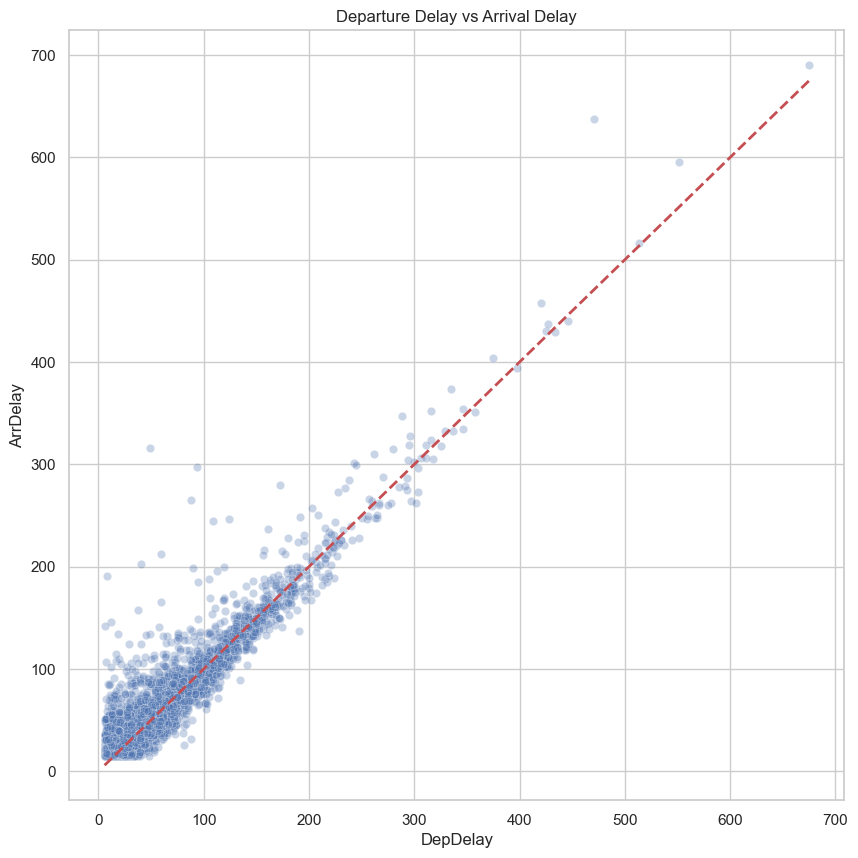

In [ ]:
pdf_scatter = df_clean.select("DepDelay", "ArrDelay").sample(False, 0.01, seed=42).toPandas()

plt.figure(figsize=(10, 10))
sns.scatterplot(x="DepDelay", y="ArrDelay", data=pdf_scatter, alpha=0.3)
plt.plot([pdf_scatter["DepDelay"].min(), pdf_scatter["DepDelay"].max()], 
         [pdf_scatter["DepDelay"].min(), pdf_scatter["DepDelay"].max()], 
         'r--', lw=2) # Identity line
plt.title("Departure Delay vs Arrival Delay")
plt.show()


# 5. Categorical Analysis
## Average Delay by Carrier


/var/folders/dk/jww3fh693dg2b9_ksjhpzs400000gn/T/ipykernel_26919/2020485812.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="UniqueCarrier", y="AvgDelay", data=carrier_delay, palette="viridis")


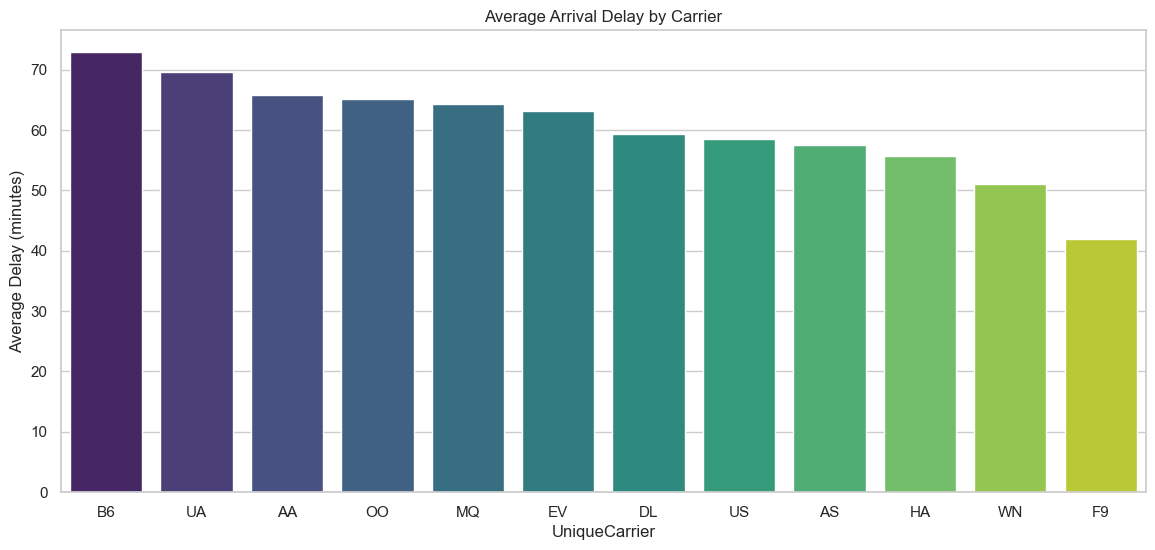

In [ ]:
carrier_delay = df_clean.groupBy("UniqueCarrier").agg(avg("ArrDelay").alias("AvgDelay"))     .orderBy("AvgDelay", ascending=False).toPandas()

plt.figure(figsize=(14, 6))
sns.barplot(x="UniqueCarrier", y="AvgDelay", data=carrier_delay, palette="viridis")
plt.title("Average Arrival Delay by Carrier")
plt.ylabel("Average Delay (minutes)")
plt.show()


# 6. Temporal Analysis
## Average Delay by Hour of Day


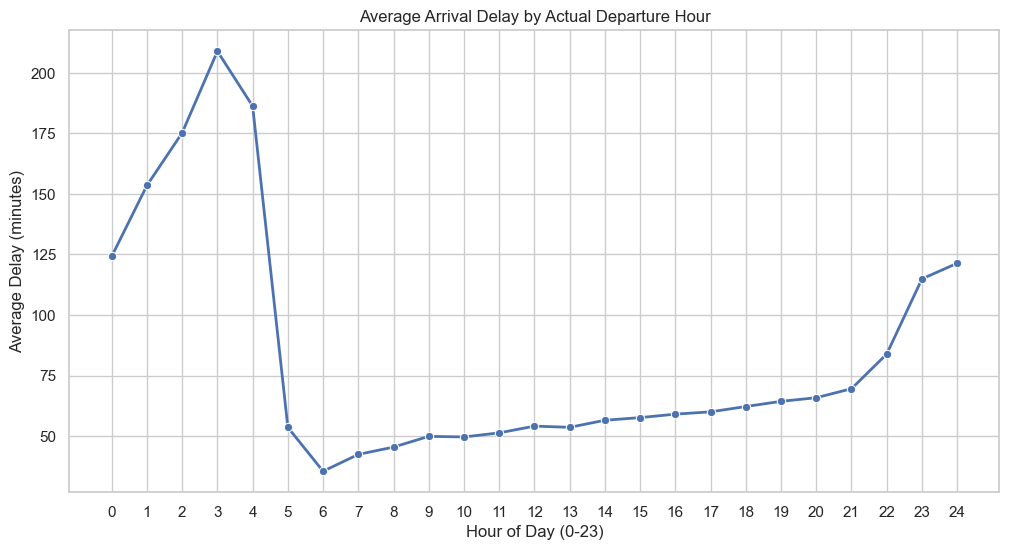

In [ ]:
df_hour = df_clean.withColumn("DepHour", (col("DepTime") / 100).cast("integer"))

hour_delay = df_hour.groupBy("DepHour").agg(avg("ArrDelay").alias("AvgDelay"))     .orderBy("DepHour").toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(x="DepHour", y="AvgDelay", data=hour_delay, marker="o", lw=2)
plt.title("Average Arrival Delay by Actual Departure Hour")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Average Delay (minutes)")
plt.xticks(range(0, 25))
plt.grid(True)
plt.show()


## Average Delay by Day of Week


/var/folders/dk/jww3fh693dg2b9_ksjhpzs400000gn/T/ipykernel_26919/1318626644.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="DayName", y="AvgDelay", data=day_delay, palette="magma")


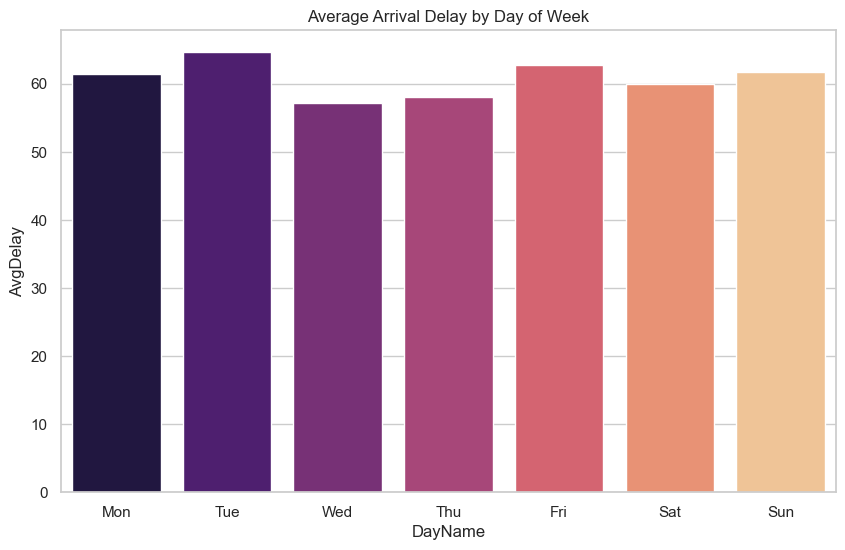

In [43]:
day_delay = df_clean.groupBy("DayOfWeek").agg(avg("ArrDelay").alias("AvgDelay"))     .orderBy("DayOfWeek").toPandas()

days = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}
day_delay['DayName'] = day_delay['DayOfWeek'].map(days)

plt.figure(figsize=(10, 6))
sns.barplot(x="DayName", y="AvgDelay", data=day_delay, palette="magma")
plt.title("Average Arrival Delay by Day of Week")
plt.show()
